In this exercise, you are going to perform simple fine tuning, teaching a pretrained version of resnet18 to tell ants from bees.

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data



--2022-10-21 07:42:34--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.10.22, 18.160.10.36, 18.160.10.28, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.10.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  59.8MB/s    in 0.8s    

2022-10-21 07:42:35 (59.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [ ]:
data_dir = "./hymenoptera_data"

num_classes = 2
batch_size = 8
num_epochs = 15


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

input_size = 224 #this value matches resnet18


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

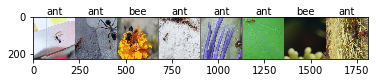

In [ ]:
#Let's print some examples:

it = iter(dataloaders_dict['train'])
images,labels = next(it)

grid=torchvision.utils.make_grid(images)

import matplotlib.pyplot as plt

def show(imgGrid,labels,types):
    nImg=len(labels)
    npimg = imgGrid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

    plotx=np.linspace(0,npimg.shape[2],nImg+1)
    plotx=np.diff(plotx)/2+plotx[:len(plotx)-1]
    [plt.text(plotx[i],0,types[labels.numpy()[i]],ha='center',va='bottom') for i in range(nImg)]


gridMin=np.min(grid.numpy())
gridMax=np.max(grid.numpy())
show((grid-gridMin)/(gridMax-gridMin),labels,('ant','bee'))



The next cell is  the only one not filled in already.

Experiment with a few different setups:

- try loading with 'pretrained=False', and see what performance you can get.
- try changing to 'pretrained=True', and see  the difference.
- try freezing and unfreezing different layers and see what it does to your accuracy

You can get the names of different layers by just printing the model.


In [ ]:
#load model and set up for fine tuning:
model_ft = models.resnet18(pretrained=True)

# optionally freeze parameters
#freeze all
'''
for param in model.parameters(): # freeze all
    param.requires_grad = False
'''
#freeze all but last conv layer
'''
for name, param in model.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False
'''
# overwrite the 'fc' layer
num_fts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fts, num_classes)

# Detect if we have a GPU available
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (torch.version.cuda)
print("Device", device)

# Send the model to GPU
model_ft.to(device)

# find parameters to update
params_to_update = []
#(loop over "name,param in model_ft.named_parameters()" and append to params_to_update if requires_grad==True)
for name, param in model_ft.named_parameters():
    print(name)
    if param.requires_grad:
        params_to_update.append(param)

# Set up optimizer for non-frozen parameters
optimizer_ft = torch.optim.Adam(params_to_update, lr=1e-4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Is the GPU available? True
11.3
Device cuda:0
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.

In [ ]:
it = iter(dataloaders_dict['train'])
images,labels = next(it)
images.size()

torch.Size([8, 3, 224, 224])

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history=[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #evaluate before training:
    model.eval()   # Set model to evaluate mode

    running_corrects = 0
    for inputs, labels in dataloaders['train']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloaders['train'].dataset)
    train_acc_history.append(acc)
    print('train acc:',acc)

    running_corrects = 0
    for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloaders['val'].dataset)
    val_acc_history.append(acc)
    print('val acc:',acc)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val, hist_train = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

train acc: tensor(0.4713, device='cuda:0', dtype=torch.float64)
val acc: tensor(0.5098, device='cuda:0', dtype=torch.float64)
Epoch 0/14
----------
train Loss: 0.4083 Acc: 0.7951
val Loss: 0.2720 Acc: 0.9085

Epoch 1/14
----------
train Loss: 0.2913 Acc: 0.8648
val Loss: 0.2624 Acc: 0.8954

Epoch 2/14
----------
train Loss: 0.2998 Acc: 0.8525
val Loss: 0.2693 Acc: 0.9281

Epoch 3/14
----------
train Loss: 0.2450 Acc: 0.8934
val Loss: 0.3578 Acc: 0.8562

Epoch 4/14
----------
train Loss: 0.1480 Acc: 0.9467
val Loss: 0.2572 Acc: 0.9085

Epoch 5/14
----------
train Loss: 0.1843 Acc: 0.9139
val Loss: 0.2987 Acc: 0.8824

Epoch 6/14
----------
train Loss: 0.2219 Acc: 0.9098
val Loss: 0.2712 Acc: 0.8954

Epoch 7/14
----------
train Loss: 0.1973 Acc: 0.9221
val Loss: 0.2720 Acc: 0.9020

Epoch 8/14
----------
train Loss: 0.1681 Acc: 0.9385
val Loss: 0.2196 Acc: 0.9216

Epoch 9/14
----------
train Loss: 0.2325 Acc: 0.8934
val Loss: 0.3158 Acc: 0.8954

Epoch 10/14
----------
train Loss: 0.2107 Ac

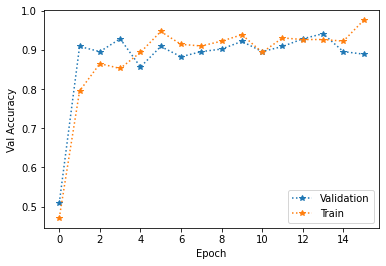

In [ ]:
import matplotlib.pyplot as plt

accs=[x.cpu().numpy() for x in hist_val]
accs=np.array(accs)
plt.plot(accs,':*')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')

accs=[x.cpu().numpy() for x in hist_train]
accs=np.array(accs)
plt.plot(accs,':*')

plt.legend(['Validation','Train'])
